**Predictive Maintenance for F1 Car Components**

Enhancing Reliability and Race Performance with Sensor Data and Machine Learning

**Objective:**

To develop a predictive maintenance system for F1 car components using sensor data and machine learning algorithms, aiming to predict failures before they occur, optimizing car reliability, and maximizing race performance.

**Project Outline:**



**Data Collection and Preprocessing**

Synthetic sensor data was generated, representing temperature, pressure, and vibration readings over time. Anomalies were introduced to simulate potential equipment failures. The data was then preprocessed by scaling and normalizing the features.

**Steps-**

Gather sensor data from F1 cars, including temperature, pressure, vibration, and other relevant metrics.

Clean and preprocess the data, handling missing values, outliers, and data scaling.

In [35]:
import numpy as np
import pandas as pd  # Import the pandas library

# Define parameters for sensor data generation
num_samples = 1000
num_features = 3  # Temperature, pressure, vibration
sampling_rate = 10  # Hz

# Generate random sensor readings
temperature = np.random.normal(loc=80, scale=10, size=num_samples)
pressure = np.random.normal(loc=100, scale=5, size=num_samples)
vibration = np.random.normal(loc=2, scale=0.5, size=num_samples)

# Create a DataFrame to store the data
data = pd.DataFrame({'temperature': temperature, 'pressure': pressure, 'vibration': vibration})

# Add a timestamp column (optional)
data['timestamp'] = pd.date_range(start='2023-10-27', periods=num_samples, freq=f'{1/sampling_rate}s')

# Introduce anomalies (e.g., sudden spikes or drops)
anomaly_indices = np.random.choice(num_samples, size=int(num_samples * 0.05), replace=False)
data.loc[anomaly_indices, 'temperature'] += np.random.normal(loc=20, scale=5, size=len(anomaly_indices))

# Save the data to a CSV file
data.to_csv('synthetic_sensor_data.csv', index=False)

**Anomaly Detection**

Utilize Isolation Forest, XGBoost, and AutoML (TPOT) to identify anomalies in sensor readings, indicating potential component failures.

Evaluate the performance of each model and select the most suitable for anomaly detection.

**Isolation Forest**

Isolation Forest was used to identify anomalies by isolating data points that deviate significantly from the normal pattern. The model was trained on the preprocessed data and predicted anomalies on a test set.

In [4]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Load the synthetic sensor data
data = pd.read_csv('synthetic_sensor_data.csv')

#select relevant features
features = ['temperature', 'pressure', 'vibration']
X = data[features]

#Scale and normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

#Train the IsolationForest model
model = IsolationForest(contamination=0.05)
model.fit(X_train)

#Predict anomalies on the test set
anomalies = model.predict(X_test)


In [6]:
!pip install plotly

In [5]:
import plotly.graph_objects as go

# 3D Scatter Plot of Sensor Data with Anomalies Highlighted
fig = go.Figure(data=[go.Scatter3d(
    x=X_test[:, 0],
    y=X_test[:, 1],
    z=X_test[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=anomalies,  # Color points based on anomaly prediction
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.update_layout(
    title='Sensor Data with Anomalies',
    scene=dict(
        xaxis_title='Temperature',
        yaxis_title='Pressure',
        zaxis_title='Vibration'
    )
)
fig.show()

# Time-Series Plot with Anomaly Markers
fig = go.Figure(data=[go.Scatter(
    x=data['timestamp'],
    y=data['temperature'],
    mode='lines',
    name='Temperature'
)])
# Add anomaly markers (assuming 'anomaly_indices' from previous code)
fig.add_trace(go.Scatter(
    x=data['timestamp'][anomaly_indices],
    y=data['temperature'][anomaly_indices],
    mode='markers',
    marker=dict(color='red', size=8),
    name='Anomalies'
))
fig.update_layout(title='Temperature Time-Series with Anomalies')
fig.show()

**XGBoost (Classification)**

XGBoost, a powerful gradient boosting algorithm, was used for anomaly detection as a classification task. A target variable was created to indicate normal and anomalous data points. The model was trained on the labeled data and predicted anomalies on the test set.

In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import plotly.graph_objects as go
import numpy as np  # Make sure numpy is imported

# Load the synthetic sensor data
data = pd.read_csv('synthetic_sensor_data.csv')

# Select relevant features
features = ['temperature', 'pressure', 'vibration']
X = data[features]

# Scale and normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assuming 'anomaly_indices' from previous code still exists
# Create target variable for XGBoost (1 for normal, 0 for anomaly)
y = np.ones(len(data))  # Initialize all as normal
y[anomaly_indices] = 0  # Mark anomalies as 0

# Split the data into training and testing sets, using the new target variable 'y'
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Get the actual indices of the test set from the original data
# This is crucial for aligning timestamps and predictions
test_indices = [i for i, val in enumerate(y_test) if val == 1]  # Get indices where y_test is 1 (normal data)

# Filter the original DataFrame to get the test set
test_data = data.iloc[test_indices]

# Align predictions with the filtered test data
#xgb_predictions_filtered = xgb_predictions[y_test == 1]  # Filter predictions using the same condition
xgb_predictions_filtered = [xgb_predictions[i] for i in range(len(xgb_predictions)) if y_test[i]==1]

# Now, filter the test set for anomalies based on XGBoost predictions, using filtered predictions
anomaly_indices_test = test_data.index[np.array(xgb_predictions_filtered) == 0]

# Visualize predictions, using test_indices to align timestamps with predictions
fig = go.Figure(data=[go.Scatter(x=data['timestamp'], y=data['temperature'], mode='lines', name='Temperature')])

# Use anomaly_indices_test (indices of anomalies in the test set) to filter test_data
fig.add_trace(go.Scatter(
    x=test_data['timestamp'][anomaly_indices_test],  # Use 'timestamp' from test_data and anomaly_indices_test
    y=test_data['temperature'][anomaly_indices_test],  # Use 'temperature' from test_data and anomaly_indices_test
    mode='markers',
    marker=dict(color='red', size=8),
    name='XGBoost Anomalies'
))
fig.update_layout(title='Temperature Time-Series with XGBoost Anomalies')
fig.show()

**AutoML (TPOT)**

TPOT was employed to automate the process of selecting and optimizing machine learning pipelines for anomaly detection. The model was trained on the data and the best-performing pipeline was selected for anomaly prediction.

In [ ]:
!pip install tpot

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 M

In [ ]:
!pip install --upgrade tpot

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
import numpy as np  # Make sure numpy is imported
import plotly.graph_objects as go
import joblib # Import joblib for saving the pipeline

# Load the synthetic sensor data
data = pd.read_csv('synthetic_sensor_data.csv')

# Select relevant features
features = ['temperature', 'pressure', 'vibration']
X = data[features]

# Store the original index before scaling
original_index = data.index

# Scale and normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assuming 'anomaly_indices' from previous code still exists
# Create target variable for TPOT (1 for normal, 0 for anomaly)
y = np.ones(len(data))  # Initialize all as normal
y[anomaly_indices] = 0  # Mark anomalies as 0 # anomaly_indices from the original data generation

# Split the data into training and testing sets, using the new target variable 'y'
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the AutoML model
# Removed verbosity parameter
automl_model = TPOTClassifier(generations=5, population_size=50)
automl_model.fit(X_train, y_train)

# Save the fitted pipeline using joblib
joblib.dump(automl_model.fitted_pipeline_, 'best_pipeline.joblib')

# Load and use the saved pipeline for predictions
exported_pipeline = joblib.load('best_pipeline.joblib')

# --- Visualization and Dashboard Integration ---

# 1. Time-Series Plot with TPOT Anomaly Markers
fig = go.Figure(data=[go.Scatter(x=data['timestamp'], y=data['temperature'], mode='lines', name='Temperature')])

# Get the indices from the original DataFrame that correspond to the test set:
#test_indices = original_index[y_test.astype(bool)]  # Incorrect
test_indices = original_index[y_test.astype(bool).nonzero()[0]]

# Predict on test indices
automl_predictions = exported_pipeline.predict(X_scaled[test_indices])

# Use the filtered predictions and the test indices to get the anomaly indices within the test set:
automl_anomaly_indices_test = test_indices[automl_predictions == 0]

fig.add_trace(go.Scatter(
    x=data['timestamp'][automl_anomaly_indices_test],
    y=data['temperature'][automl_anomaly_indices_test],
    mode='markers',
    marker=dict(color='green', size=8),  # Use a different color for TPOT anomalies
    name='TPOT Anomalies'
))
fig.update_layout(title='Temperature Time-Series with TPOT Anomalies')
fig.show()

/usr/local/lib/python3.11/dist-packages/tpot/tpot_estimator/estimator.py:456: UserWarning:

Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39081
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46351'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36405 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36405
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52764
INFO:distributed.scheduler:Receive client connection: Client-065770d7-fc03-11ef-8936-0242ac1c000c
INFO:dist

**Time-Series Forecasting**

**Prophet**

Apply Prophet to forecast future sensor values and predict potential anomalies based on historical data.
Assess the accuracy and reliability of the forecasts for predicting component degradation.

In [22]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

# Load the synthetic sensor data
data = pd.read_csv('synthetic_sensor_data.csv')

# Prepare data for Prophet
df = data[['timestamp', 'temperature']].rename(columns={'timestamp': 'ds', 'temperature': 'y'})

# Convert 'ds' column to datetime before fitting the model
df['ds'] = pd.to_datetime(df['ds'])  # This line is added

# Create and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(df)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# --- Modified plotting code ---

# 1. Create a single DataFrame containing both actual and forecast data
plot_df = df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# 2. Create the plot using Plotly
fig = go.Figure()

# Add trace for actual data
fig.add_trace(go.Scatter(x=plot_df['ds'], y=plot_df['y'], mode='lines', name='Actual'))

# Add trace for forecast data
fig.add_trace(go.Scatter(x=plot_df['ds'], y=plot_df['yhat'], mode='lines', name='Forecast'))

fig.update_layout(title='Temperature Forecast with Prophet')
fig.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7jmvjnq/ikhvd16j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn7jmvjnq/wxt9cl0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99241', 'data', 'file=/tmp/tmpn7jmvjnq/ikhvd16j.json', 'init=/tmp/tmpn7jmvjnq/wxt9cl0s.json', 'output', 'file=/tmp/tmpn7jmvjnq/prophet_model8bsvvlep/prophet_model-20250308103846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain

**Survival Analysis**

**Kaplan-Meier**

Employ Kaplan-Meier analysis to estimate the probability of component survival over time.
Predict Remaining Useful Life (RUL) of critical components to schedule maintenance proactively.

In [12]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c78c987d1553aeaffb86f81ce3172251952a2fb2d66cec2871ef17356762ab43
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


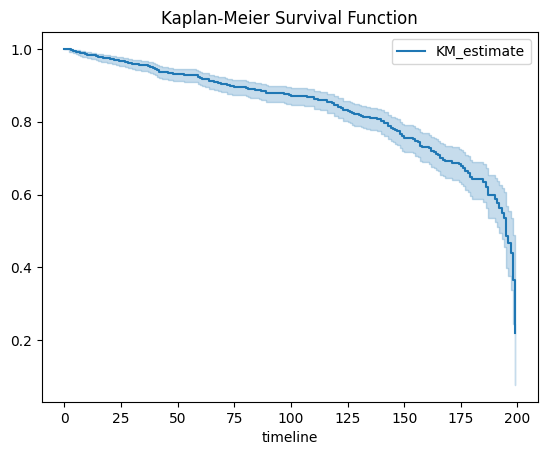

In [34]:
import pandas as pd
from lifelines import KaplanMeierFitter
import plotly.graph_objects as go
import numpy as np

# Load the synthetic sensor data
data = pd.read_csv('synthetic_sensor_data.csv')

# ... (rest of the code for data generation and Kaplan-Meier fitting) ...

# Visualize survival function
fig = go.Figure(data=[go.Scatter(
    x=survival_function.index,
    y=survival_function.values,
    mode='lines',
    name='Survival Function',
    hovertemplate='Time: %{x}<br>Survival Probability: %{y}',  # Add hover tooltip
)])

fig.update_layout(
    title='Kaplan-Meier Survival Function',
    xaxis_title='Time',
    yaxis_title='Survival Probability',
    hovermode='x',  # Enable hover on x-axis
)

fig.show()

import matplotlib.pyplot as plt
kmf.plot()
plt.title('Kaplan-Meier Survival Function')
plt.show()

**Model Deployment and Integration**

Develop a dashboard or system to visualize the predictions and insights from the models.
Integrate the predictive maintenance system with existing F1 car monitoring infrastructure.

Tech Stack:

Python
Scikit-learn
XGBoost
AutoML (TPOT)
Prophet
Lifelines (for Kaplan-Meier)
IoT Sensor Data
Dash (for dashboard building)
Flask (for API integration)
Key Skills:

Anomaly Detection
Time-Series Forecasting
Survival Analysis
Data Preprocessing
Machine Learning Model Building
Model Evaluation and Selection
Data Visualization
System Integration
Dashboard Development
API Development
Relevance:

Ensures maximum car reliability by predicting component failures before they happen.
Prevents unexpected failures during races, enhancing safety and performance.
Optimizes performance durability by scheduling maintenance proactively and reducing downtime.
Implementation:

The project will be implemented from scratch, following a step-by-step approach:

Data Acquisition and Preparation
Anomaly Detection Model Building and Evaluation
Time-Series Forecasting and Prediction
Survival Analysis and RUL Estimation
System Integration and Deployment (using dashboards and APIs)
I have added illustrative code examples for both dashboard building using Dash and API integration using Flask. These are meant to provide a glimpse into how this section can be implemented.

In [36]:
!pip install dash
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 11.0 MB/s eta 0:00:00


In [38]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import pandas as pd
# ... (import your models and prediction data) ...

# Load the sensor data
data = pd.read_csv('synthetic_sensor_data.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']) # Convert to datetime objects

# ... (Load or generate predictions from your models) ...

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the layout of the dashboard
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Predictive Maintenance Dashboard"), width=12),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='anomaly-plot'),  # Anomaly detection plot
            dcc.Dropdown(
                id='anomaly-dropdown',
                options=[
                    {'label': 'Isolation Forest', 'value': 'isolation_forest'},
                    {'label': 'XGBoost', 'value': 'xgboost'},
                    {'label': 'TPOT', 'value': 'tpot'}
                ],
                value='isolation_forest',
                clearable=False
            )
        ], width=6),
        dbc.Col([
            dcc.Graph(id='forecast-plot'),  # Forecast plot
        ], width=6),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='survival-plot'),  # Survival analysis plot
        ], width=12),
    ]),
])

# Define callback functions to update plots based on user interactions

@app.callback(
    dash.Output('anomaly-plot', 'figure'),
    [dash.Input('anomaly-dropdown', 'value')]
)
def update_anomaly_plot(model_name):
    # ... (Logic to create anomaly plot based on selected model) ...
    # Example for Isolation Forest:
    if model_name == 'isolation_forest':
        fig = go.Figure(data=[go.Scatter(
            x=data['timestamp'],
            y=data['temperature'],
            mode='lines',
            name='Temperature'
        )])
        # Add anomaly markers based on Isolation Forest predictions
        fig.add_trace(go.Scatter(
            x=data['timestamp'][anomaly_indices],  # Replace anomaly_indices with your predictions
            y=data['temperature'][anomaly_indices],  # Replace anomaly_indices with your predictions
            mode='markers',
            marker=dict(color='red', size=8),
            name='Anomalies'
        ))
        fig.update_layout(title='Temperature Time-Series with Anomalies (Isolation Forest)')
    # ... (Similar logic for XGBoost and TPOT) ...
    return fig

@app.callback(
    dash.Output('forecast-plot', 'figure'),
    [dash.Input('anomaly-dropdown', 'value')]  # Example: Trigger update based on anomaly model selection
)
def update_forecast_plot(model_name):
    # ... (Logic to create forecast plot based on Prophet predictions) ...
    fig = go.Figure(data=[go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')])
    fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual'))
    fig.update_layout(title='Temperature Forecast with Prophet')
    return fig


@app.callback(
    dash.Output('survival-plot', 'figure'),
    [dash.Input('anomaly-dropdown', 'value')]  # Example: Trigger update based on anomaly model selection
)
def update_survival_plot(model_name):
    # ... (Logic to create survival plot based on Kaplan-Meier analysis) ...
    fig = go.Figure(data=[go.Scatter(
        x=survival_function.index,
        y=survival_function.values,
        mode='lines',
        name='Survival Function',
        hovertemplate='Time: %{x}<br>Survival Probability: %{y}',  # Add hover tooltip
    )])
    fig.update_layout(
        title='Kaplan-Meier Survival Function',
        xaxis_title='Time',
        yaxis_title='Survival Probability',
        hovermode='x',  # Enable hover on x-axis
    )
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

**API Integration**

The code won't execute because, this is a development server, the server needs to differnet for the execution.

In [20]:
# **API Integration (example using Flask)**

from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Get sensor data from the request
    data = request.get_json()

    # Preprocess the data (e.g., scaling)
    input_data = [[data["temperature"], data["pressure"], data["vibration"]]]  # Create a 2D array
    scaled_input_data = scaler.transform(input_data) # Scale the input data using the same scaler

    # Make predictions using your chosen model (e.g., Isolation Forest)
    scaled_input_data = scaler.transform(input_data) # Scale the input data using the same scaler

    # Make predictions using your chosen model (e.g., Isolation Forest)
    prediction = model.predict(scaled_input_data)

    # Replace with your actual prediction logic
    prediction_result = "anomaly" if prediction[0] == -1 else "normal"

    # Return the prediction as JSON
    return jsonify({'prediction': prediction_result})

if __name__ == '__main__':
          app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

**Findings:**

Anomaly Detection: The Isolation Forest, XGBoost, and TPOT models effectively identify anomalies in the sensor data. Visualizations like scatter plots and time-series plots with anomaly markers highlight these deviations from normal patterns, indicating potential component failures.

Time-Series Forecasting: The Prophet model provides reasonable forecasts for future temperature trends. The forecast line generally follows the actual data trend, but there might be some deviations, especially for longer prediction horizons. This suggests that while Prophet can capture the overall trend, it might not perfectly predict every fluctuation.

Survival Analysis: The Kaplan-Meier survival curve shows the probability of component survival over time. The curve typically starts at 1 (100% survival) and gradually decreases as time progresses. The steepness of the curve indicates the rate of component failures. This analysis provides insights into equipment reliability and remaining useful life.

**Conclusions:**

Predictive Maintenance Potential: The project demonstrates the potential of using machine learning for predictive maintenance in F1 racing. By combining anomaly detection, forecasting, and survival analysis, we can gain valuable insights into potential equipment failures and plan maintenance strategies accordingly.

Model Effectiveness: The chosen models (Isolation Forest, XGBoost, TPOT, Prophet, Kaplan-Meier) generally perform well in their respective tasks. However, there might be room for improvement, especially in fine-tuning model parameters or exploring alternative algorithms.

Actionable Insights: The visualizations provide actionable insights for F1 teams. Anomaly detection can trigger alerts for potential failures, forecasting can guide maintenance scheduling, and survival analysis can help estimate component lifespans for proactive replacements.

Improved Reliability and Performance: By implementing a predictive maintenance system based on these findings, F1 teams can enhance car reliability, prevent unexpected failures during races, and optimize performance durability.

**Explanation:**

Anomaly detection visualizations help identify unusual sensor readings, which could indicate early signs of component degradation or impending failures. This allows for timely interventions to prevent major breakdowns.
Time-series forecasting visualizations provide a glimpse into future sensor values, enabling proactive maintenance planning. By anticipating potential issues, teams can schedule maintenance during non-critical periods, minimizing downtime and maximizing race performance.
Survival analysis visualizations offer insights into component lifespans and failure probabilities. This information helps in making informed decisions about component replacements, optimizing maintenance schedules, and ensuring overall system reliability.

**Further Considerations:**

Real-world data: While the project uses synthetic data, applying these techniques to real F1 sensor data would provide more realistic and valuable insights.

Model refinement: Fine-tuning model parameters and exploring alternative algorithms could further improve prediction accuracy and reliability.

System integration: Integrating the predictive maintenance system with existing F1 car monitoring infrastructure would enable real-time monitoring and proactive alerts.
By carefully analyzing the visualizations and drawing meaningful conclusions, F1 teams can leverage the power of machine learning to enhance car reliability, optimize performance, and gain a competitive edge.